# JAX Implementation of a CSTR controlled by a PID Controller

## Open Loop Simulation

In [2]:
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5
import jax
import jax.numpy as jnp
import numpy as np


def react(t, y, args):
    Ca, T = y
    q, V, rho, C, deltaHr, EA_over_R, k0, UA, Ti, caf, Tc = args
   
    rA = k0 * jnp.exp(-EA_over_R / T) * Ca
    d_Ca = q/V * (caf - Ca) - rA
    d_T = q/V * (Ti - T) + ((-deltaHr) * rA) * (1 / (rho * C)) + UA * (Tc - T) * (1 / (rho * C * V))
   
    d_y = jnp.array([d_Ca, d_T])  # Return a flat array of derivatives
    return d_y

args = (100, 100, 1000, 0.239, -5e4, 8750, 7.2e10, 5e4, 350, 1, 270)  
term = ODETerm(react)
solver = Tsit5()
t0 = 0
t1 = 25
dt0 = 0.1
y0 = jnp.array([0.1, 370.0])  # Make sure y0 is a flat array

saveat = SaveAt(ts=jnp.linspace(t0, t1, 1000))
sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)




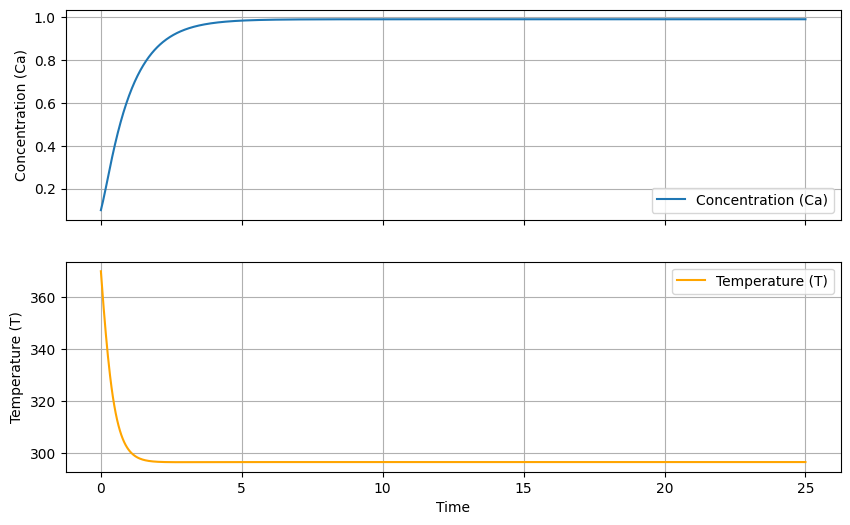

In [3]:
import matplotlib.pyplot as plt

# Plot the results on separate subplots
t_values = sol.ts
Ca_values = sol.ys[:, 0]  # Concentration Ca
T_values = sol.ys[:, 1]  # Temperature T

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_values, Ca_values, label='Concentration (Ca)')
ax1.set_ylabel('Concentration (Ca)')
ax1.legend()
ax1.grid(True)
ax2.plot(t_values, T_values, label='Temperature (T)', color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Temperature (T)')
ax2.legend()
ax2.grid(True)

plt.show()

## Closed Loop Simulation


### PID Controller

In [4]:
import jax.numpy as jnp

class PID:
    def __init__(self, Kp, Ki, Kd, setpoint, output_limits):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.prev_error = 0.0
        self.integral = 0.0
        self.output_limits = output_limits
        self.output_store = []

    def control(self, process_variable):
        error =  process_variable - self.setpoint
        self.integral += error
        derivative = error - self.prev_error
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        output = jnp.clip(output,self.output_limits[0],self.output_limits[1])
        self.prev_error = error
        self.output_store.append(output)
    
        return output
    def control_signals(self):
        print('true')
        return self.output_store

In [8]:
def react(t, y, args):
    Ca, T, c_signal = y
    q, V, rho, C, deltaHr, EA_over_R, k0, UA, Ti, caf, SP,Tc = args
    c_signal = 0.
    # Initialize and configure the PID controller for controlling Ca
    pid = PID(Kp=20, Ki=200, Kd=0.0, setpoint=SP, output_limits=(-5, 5))
    # Calculate the control signal using the PID controller
    c_signal = pid.control(Ca)
    Tc = Tc + c_signal
    
    rA = k0 * jnp.exp(-EA_over_R / T) * Ca

    # Compute the derivatives
    d_Ca = q/V * (caf - Ca) - rA  
    d_T = q/V * (Ti - T) + ((-deltaHr) * rA) * (1 / (rho * C)) + UA * (Tc - T) * (1 / (rho * C * V))
    
    d_y = jnp.array([d_Ca, d_T,c_signal])  # Return a flat array of derivatives
    return d_y

In [6]:
t_step = 3000
SP = 0.8
args = (100., 100., 1000., 0.239, -5.e4, 8750., 7.2e10, 5.e4, 350., 1., SP,300.)  
term = ODETerm(react)
solver = Tsit5()
t0 = 0
t1 = 25
dt0 = 0.1
y0 = jnp.array([0.1, 370.0,295]) # Make sure y0 is a flat array

saveat = SaveAt(ts=jnp.linspace(t0, t1, t_step))
sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)

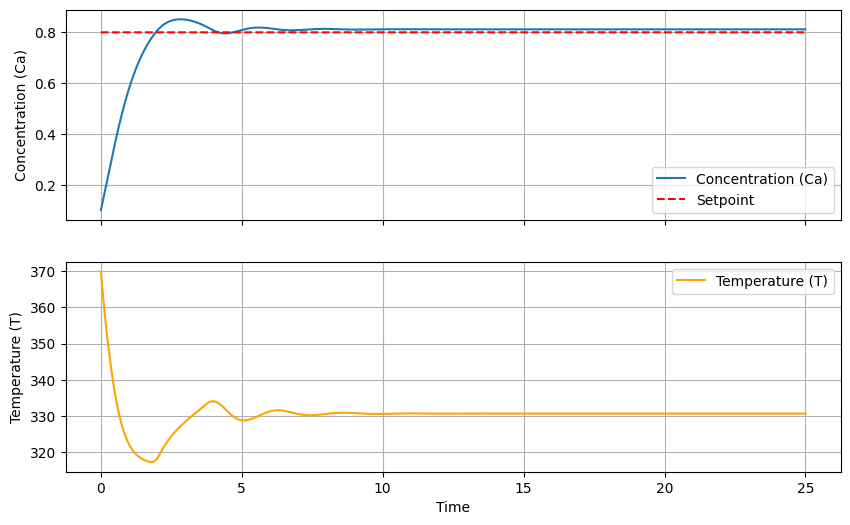

In [7]:

t_values = sol.ts
Ca_values = sol.ys[:, 0]  # Concentration Ca
T_values = sol.ys[:, 1]  # Temperature T
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
SP = [SP for i in range(int(t_step))] 
ax1.plot(t_values, Ca_values, label='Concentration (Ca)')
ax1.plot(t_values,SP,'--',color ='red',label = 'Setpoint')
ax1.set_ylabel('Concentration (Ca)')
ax1.legend()
ax1.grid(True)
ax2.plot(t_values, T_values, label='Temperature (T)', color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Temperature (T)')
ax2.legend()
ax2.grid(True)
plt.show()